# Proyecto de series temporales

In [37]:
# importaciones
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima import auto_arima
import joblib

## 1. Carga del conjunto de datos

In [38]:
# Cargar el dataset
url = "https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv"
df = pd.read_csv(url)

# Visualizar las primeras filas
df.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


In [39]:
# Validar los tipos de dato, y si hay nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    366 non-null    object 
 1   sales   366 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


In [40]:
# Convertir la columna de fechas a datetime
df['date'] = pd.to_datetime(df['date'])

# Establecer la fecha como índice
df.set_index('date', inplace=True)

# Convertir la columna de ventas a float32
df['sales'] =  df['sales'].astype('float32')

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 366 entries, 2022-09-03 17:10:08.079328 to 2023-09-03 17:10:08.079328
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sales   366 non-null    float32
dtypes: float32(1)
memory usage: 4.3 KB


In [42]:
df.isnull().sum()

sales    0
dtype: int64

## 2. Construye y analiza la serie temporal

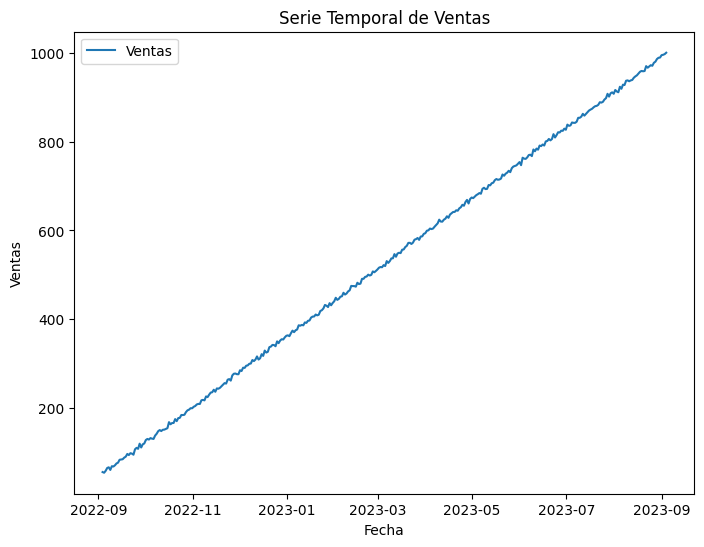

In [43]:
# Graficar la serie temporal
plt.figure(figsize=(8, 6))
plt.plot(df['sales'], label='Ventas')
plt.title('Serie Temporal de Ventas')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.show()

In [44]:
# Inspeccionar el índice del DataFrame para determinar la frecuencia
print(df.index.freq)  # Si está configurada
print(df.index[1] - df.index[0])  # Diferencia entre dos fechas consecutivas

None
1 days 00:00:00


**Observacion:** 
- El tensor es la unidad de tiempo mínima para la cual hay datos, en este dataset el tensor es diario
- Tambien, de la gráfica se interpreta que la tendencia de las ventas es ascendente

In [45]:
# Usar la prueba ADF (Augmented Dickey-Fuller) para verificar estacionariedad
result = adfuller(df['sales'])
print('Estadístico ADF:', result[0])
print('p-valor:', result[1])

Estadístico ADF: 0.5454129056159569
p-valor: 0.9861899459260359


**Observacion:** 
- p-valor > 0.05 y alto 0.986 indica que no es posible rechazar la hipótesis nula de la prueba ADF, que establece que la serie no es estacionaria.
- Estadístico ADF positivo 0.545, siendo un valor positivo y cercano a cero se refuerza la conclusión de que la serie no es estacionaria.
- Para que la serie sea estacionaria, el estadístico ADF debería ser más negativo y el p-valor debería ser menor a 0.05.
- Dado que la serie no es estacionaria, el paso recomendado es aplicar diferenciación para eliminar la tendencia. La diferenciación consiste en restar el valor de una observación al valor de la observación anterior, que es el proceso a seguir.

In [46]:
# Aplicar diferenciación de orden 1
df_diff = df['sales'].diff().dropna()  # .diff() calcula la diferencia, .dropna() elimina el valor NaN inicial

# Realizar la prueba ADF en la serie diferenciada
result_diff = adfuller(df_diff)
print('Estadístico ADF (diferenciada):', result_diff[0])
print('p-valor (diferenciada):', result_diff[1])

Estadístico ADF (diferenciada): -9.430271125065142
p-valor (diferenciada): 5.212709605780142e-16


**Observación:** 
- Con la difeenciacion aplicada, se ha logrado eliminar la tendencia y asi el p-valor es <0.05 por lo que ya podemos rechazar la hipotesis nula y aceptamos que una serie es estacionaria por lo que ya es posible usar el modelo ARIMA.
- La diferenciación de orden 1 (df['sales'].diff()) fue suficiente para hacer la serie estacionaria. Esto significa que el parámetro d=1 es apropiado para el modelo ARIMA

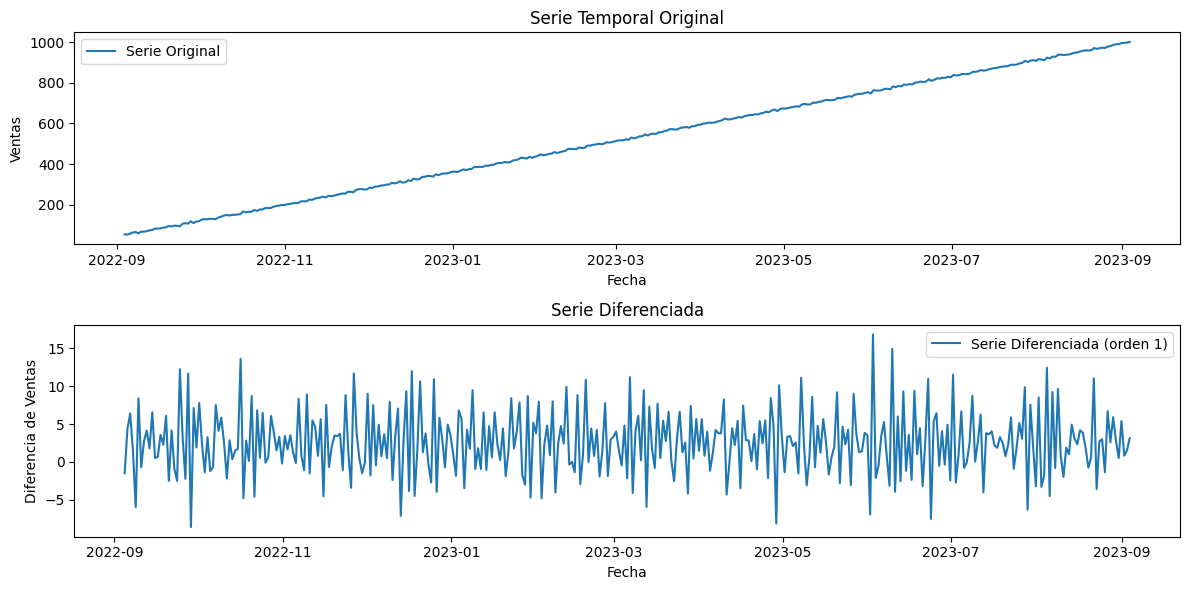

In [47]:
# Confirmar visualmente la estacionariedad
# Graficar serie original y diferenciada
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(df['sales'], label='Serie Original')
plt.title('Serie Temporal Original')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(df_diff, label='Serie Diferenciada (orden 1)')
plt.title('Serie Diferenciada')
plt.xlabel('Fecha')
plt.ylabel('Diferencia de Ventas')
plt.legend()

plt.tight_layout()
plt.show()

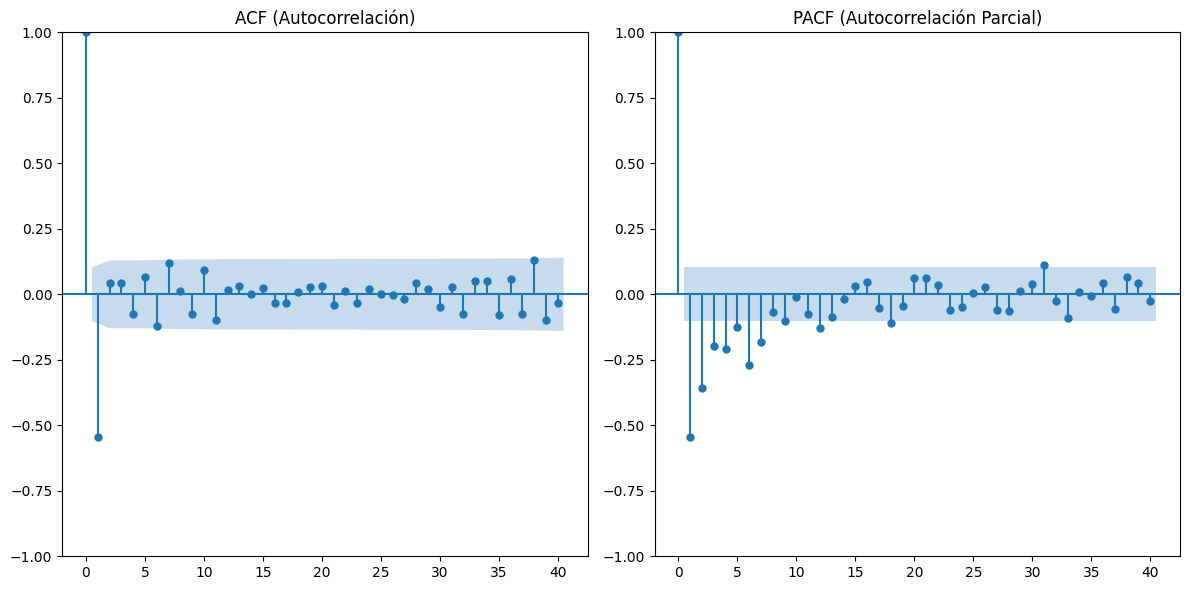

In [48]:
# Estimar los parametros de p y q
# Graficar ACF y PACF de la serie diferenciada
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_acf(df_diff, lags=40, ax=plt.gca())
plt.title('ACF (Autocorrelación)')

plt.subplot(1, 2, 2)
plot_pacf(df_diff, lags=40, ax=plt.gca())
plt.title('PACF (Autocorrelación Parcial)')

plt.tight_layout()
plt.show()

**Determinación de parámetros ARIMA**  
Basado en el análisis:
- p = 1: Debido al pico significativo en el lag 1 del PACF.
- q = 1: Debido al pico significativo en el lag 1 del ACF.
- d = 1: Confirmado previamente por la prueba ADF tras la diferenciación.

## 3. Entrena un ARIMA

In [49]:
# Dividir en entrenamiento y prueba (80% entrenamiento, 20% prueba)
train_size = int(len(df) * 0.8)
train, test = df['sales'][:train_size], df['sales'][train_size:]

# Ajustar el modelo ARIMA(1, 1, 1)
model = ARIMA(train, order=(1, 1, 1))
fitted_model = model.fit()
print(fitted_model.summary())

/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  292
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -838.546
Date:                Tue, 05 Aug 2025   AIC                           1683.093
Time:                        16:36:51   BIC                           1694.113
Sample:                    09-03-2022   HQIC                          1687.507
                         - 06-21-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.001    875.209      0.000       0.998       1.002
ma.L1         -0.9995      0.871     -1.147      0.251      -2.707       0.708
sigma2        18.3332     16.053      1.142      0.2

/home/vscode/.local/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## 4. Predice con el conjunto de test

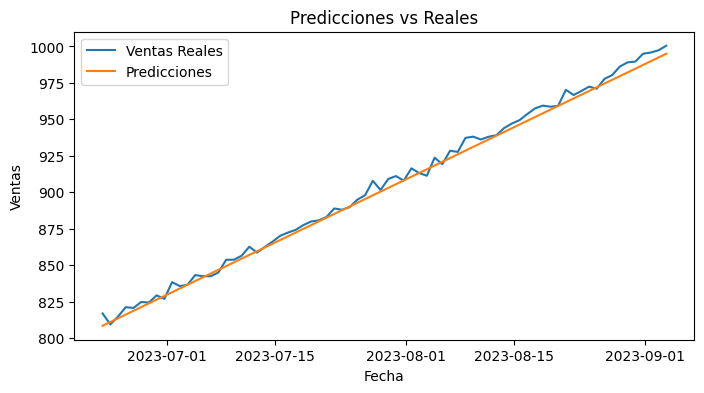

In [50]:
# Predecir en el conjunto de prueba
predictions = fitted_model.forecast(steps=len(test))

# Crear DataFrame para comparar
results = pd.DataFrame({'Real': test, 'Predicho': predictions}, index=test.index)

# Graficar resultados
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.plot(results['Real'], label='Ventas Reales')
plt.plot(results['Predicho'], label='Predicciones')
plt.title('Predicciones vs Reales')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.show()

In [51]:
# Evaluar el rendimiento
mse = mean_squared_error(test, predictions)
mae = mean_absolute_error(test, predictions)
mape = (abs(test - predictions) / test).mean() * 100
print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape:.2f}%')

MSE: 16.62300489911188
MAE: 3.2919137496311888
MAPE: 0.36%


In [52]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                  292
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -838.546
Date:                Tue, 05 Aug 2025   AIC                           1683.093
Time:                        16:36:51   BIC                           1694.113
Sample:                    09-03-2022   HQIC                          1687.507
                         - 06-21-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.001    875.209      0.000       0.998       1.002
ma.L1         -0.9995      0.871     -1.147      0.251      -2.707       0.708
sigma2        18.3332     16.053      1.142      0.253     -13.129      49.796
===================================================================================
Ljung-Box (L1) (Q):                  83.14   Jarque-Bera (JB):                 2.74
Prob(Q):                              0.00   Prob(JB):                         0.25
Heteroskedasticity (H):               1.07   Skew:                             0.24
Prob(H) (two-sided):                  0.74   Kurtosis:                         3.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Análisis**
- El modelo ARIMA(1, 1, 1) tiene un término autorregresivo significativo 1.0 , pero el término de media móvil (ma.L1) no lo es, lo que indica que se requieren ajustes.
- La autocorrelación residual significativa (Ljung-Box, p=0.00) indica que el modelo no explica toda la estructura temporal de los datos, lo que podría deberse a estacionalidad no modelada (dado que el tensor es diario y podría haber un patrón semanal).
- Las métricas MSE, MAE, MAPE son razonables, pero la falta de ajuste completo sugiere que el modelo puede mejorarse.

### Mejorar los parametros con auto_arima

In [ ]:
# Modelo 2 con auto arima
model2 = auto_arima(df['sales'], seasonal=True, m=7, d=1, trace=True, error_action='ignore', suppress_warnings=True)
print(model2.order)  # (p, d, q)
print(model2.seasonal_order)  # (P, D, Q, m)
fitted_model2 = model2.fit(train)
print(fitted_model2.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=1.93 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=2096.543, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=1966.396, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=2209.657, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=1970.972, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=1968.120, Time=0.26 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=1968.220, Time=0.20 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=1966.919, Time=0.13 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=1965.376, Time=0.71 sec
 ARIMA(1,1,0)(2,0,2)[7] intercept   : AIC=1965.211, Time=0.77 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=1963.937, Time=0.50 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=1967.822, Time=0.28 sec
 ARIMA(0,1,0)(1,0,2)[7] intercept   : AIC=2094.918, Time=0.48 sec
 ARIMA(2,1,0)(1,0,2)[7] intercept   : AIC=1

In [57]:
# Predecir en el conjunto de prueba
predictions2 = fitted_model2.predict(n_periods=len(test), return_conf_int=False)

# Evaluar el rendimiento
mse2 = mean_squared_error(test, predictions2)
mae2 = mean_absolute_error(test, predictions2)
mape2 = (abs(test - predictions2) / test).mean() * 100
print(f"MSE: {mse2}")
print(f"MAE: {mae2}")
print(f"MAPE: {mape2:.2f}%")

MSE: 7.689077980093468
MAE: 2.23603359179779
MAPE: 0.25%


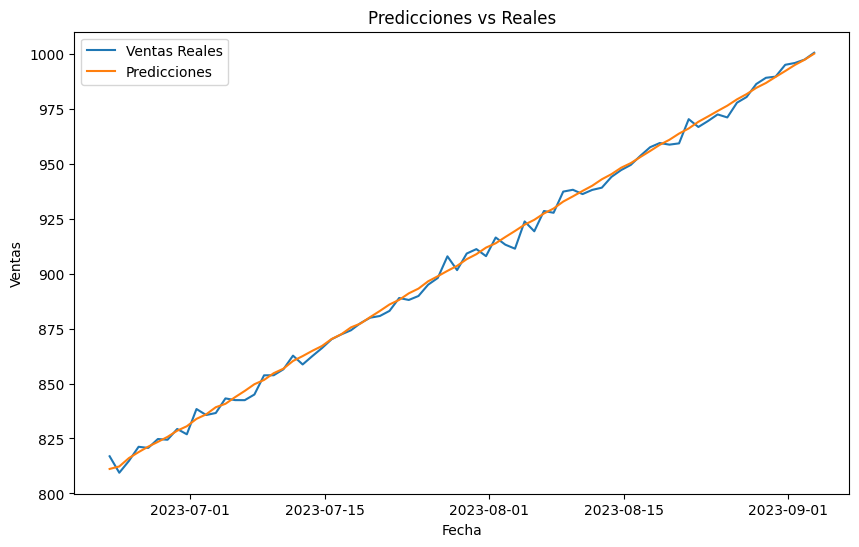

In [58]:
# Graficar resultados
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(test.index, test, label='Ventas Reales')
plt.plot(test.index, predictions2, label='Predicciones')
plt.title('Predicciones vs Reales')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.show()

In [63]:
print('-------- Modelo ARIMA (1,1,1) --------')
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape:.2f}%")

print('--- Modelo SARIMA(2,1,1)(1,0,2)[7] ---')
print(f"MSE: {mse2}")
print(f"MAE: {mae2}")
print(f"MAPE: {mape2:.2f}%")

-------- Modelo ARIMA (1,1,1) --------
MSE: 16.62300489911188
MAE: 3.2919137496311888
MAPE: 0.36%
--- Modelo SARIMA(2,1,1)(1,0,2)[7] ---
MSE: 7.689077980093468
MAE: 2.23603359179779
MAPE: 0.25%


**Observaiones:**
- Errores: El SARIMA(2,1,1)(1,0,2)[7] tiene un desempeño superior, con un MSE casi la mitad (7.69 vs. 16.65), un MAE más bajo (2.24 vs. 3.30), y un MAPE reducido (0.25% vs. 0.36%). Esto refleja una mayor precisión en las predicciones, probablemente debido a la captura de la estacionalidad semanal.
- Coeficientes: El ARIMA(1,1,1) depende principalmente de un término AR significativo, pero su MA no lo es, por lo que no es óptimo.
- El SARIMA incorpora términos estacionales significativos y un MA más robusto, La inclusión de estos y el intercepto en el SARIMA ofrecen un mejor ajuste.
- El SARIMA resuelve la autocorrelación residual, un punto débil del ARIMA(1,1,1), lo que confirma que el modelo estacional es más adecuado para los datos diarios de este dataset.
- ARIMA(1,1,1): El primer intento, fue útil pero es limitado por no considerar estacionalidad.
- SARIMA(2,1,1)(1,0,2)[7]: El modelo final, optimizado con auto_arima, refleja la estacionalidad semanal.

## 5. Guardar el modelo

In [59]:
joblib.dump(fitted_model, '/workspaces/AleGomezM-4GSeriesTemporales/models/arima_model.pkl')
joblib.dump(fitted_model2, '/workspaces/AleGomezM-4GSeriesTemporales/models/arima_model2.pkl')

['/workspaces/AleGomezM-4GSeriesTemporales/models/arima_model2.pkl']